# Practice 2

Student 1: Alejandro González Álvarez

NIA 1: 252658

Student 2: Luca Franceschi

NIA 2: 253885

Student 3: Júlia Othats-Dalès

NIA 3: 254435

# Imports

In [32]:
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Google Drive (or not)

In [2]:
# Comment if not in Google Colab
from google.colab import drive
drive.mount('/content/drive')

datadir = '/content/drive/My Drive/DeepLearning_2024/P2/Data/'
#datadir = 'Data/'

Mounted at /content/drive


# GPU Acceleration (or not)

In [33]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Ex.1 - Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs

In [ ]:
'''
Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs
Steps :
1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.
2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:
  -   Adapt the classification loss and the SequenceClassifier module
  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix
3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.
4. Visualize analyse and discuss the results in the report.
'''

"\nExperimenting with Multi-Class Sequence Classification using RNNs and LSTMs\nSteps :\n1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.\n2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:\n  -   Adapt the classification loss and the SequenceClassifier module\n  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix\n3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.\n4. Visualize analyse and discuss the results in the report.\n"

# Sol 1.

Train Seqs: (210, 40)
Train Labels: (210,)
Test Seqs: (90, 40)
Test Labels: (90,)


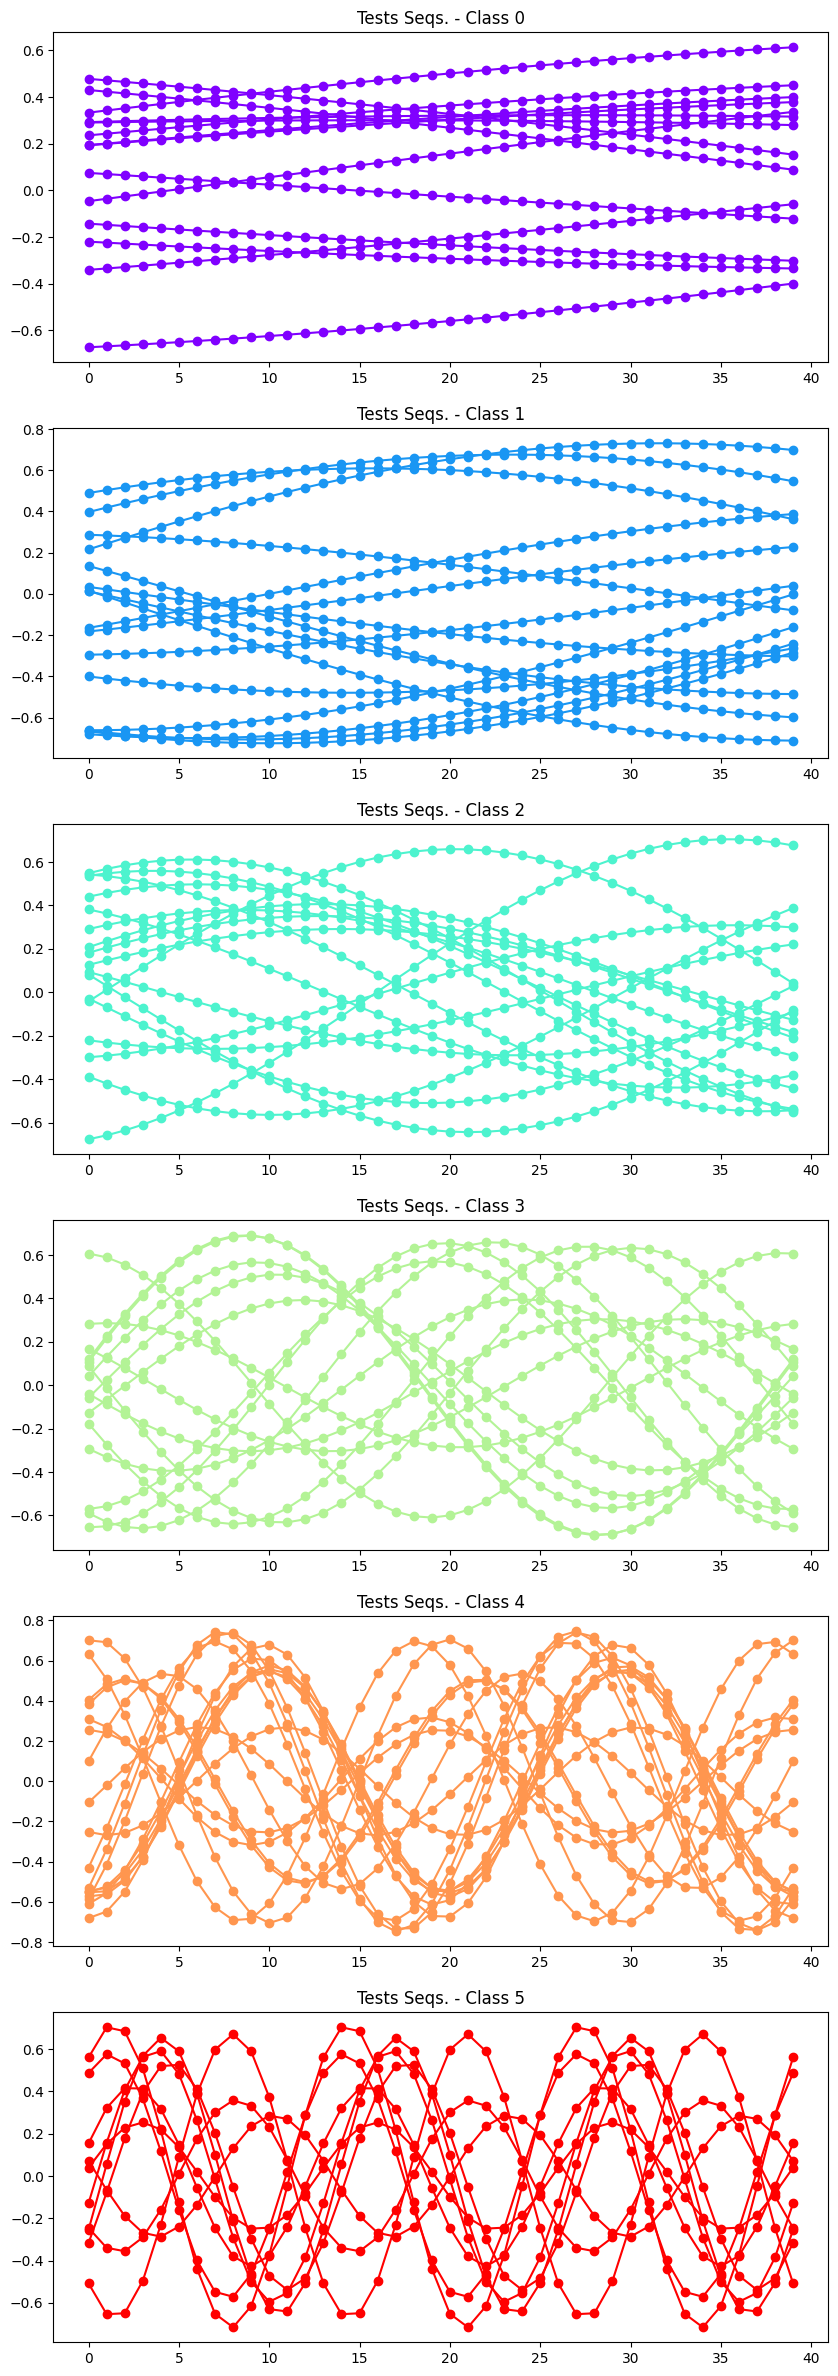

In [ ]:
# 1. Load and visualize the training and testing data
data = np.load(datadir+'P2_E1.npz')
X_train, X_test = data['X_train'], data['X_test']
Y_train, Y_test = data['Y_train'], data['Y_test']

print(f'Train Seqs: {X_train.shape}')
print(f'Train Labels: {Y_train.shape}')
print(f'Test Seqs: {X_test.shape}')
print(f'Test Labels: {Y_test.shape}')

classes = np.unique(Y_train)
n_classes = len(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

fig, axs = plt.subplots(n_classes, 1, figsize=(10, 5*n_classes))
for class_idx in range(0, n_classes):
    axs[class_idx].plot(X_test[Y_test == class_idx, :].T, '-o', c=colors[class_idx])
    axs[class_idx].set_title(f'Tests Seqs. - Class {class_idx}')
fig.show()

In [ ]:
# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters

class SequenceClassifier(nn.Module):
    def __init__(self,
                 input_size : int = 1,
                 hidden_size : int = 5,
                 num_layers = 1,
                 num_classes : int = 6,
                 use_lstm : bool = False):
        # Define RNN or LSTM architecture
        super().__init__()
        self.use_lstm = use_lstm
        if(use_lstm):
            self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                               num_layers=num_layers, batch_first = True)
        else:
            self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size,
                              num_layers=num_layers, batch_first = True)
        self.softmax = nn.Softmax(dim=1)
        self.last_linear = nn.Linear(hidden_size, num_classes)  # 6 is number of different classes

    def forward(self, X):
        _, last_states = self.rnn(X)
        # Get last hidden state for last layer. Ignore cell state in case of LSTMs
        if(not self.use_lstm):
            last_hidden_state = last_states[-1,:,:].squeeze(0)
        else:
            last_hidden_state = last_states[0][-1,:,:].squeeze(0)
        # Get sequence label probability using the last hidden state
        output = self.softmax(self.last_linear(last_hidden_state))  # Using softmax instead of sigmoid
        return output

In [ ]:
# Define the training model
def train_multiclass_classifier(X_train, Y_train, classifier, optimizer, loss_func, epochs=100):
    loss_epochs = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = classifier(X_train)
        loss = loss_func(output, Y_train)
        loss_epochs.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_epochs)

# Adapt the test_sequence_classifier function
def test_multiclass_classifier(X_test, Y_test, classifier):
    output = classifier(X_test)
    predicted_labels = torch.argmax(output, dim=1)
    correct_predictions = (predicted_labels == Y_test).sum().item()
    total_samples = len(Y_test)
    accuracy = correct_predictions / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y_test.to(device), predicted_labels.to(device))

    return accuracy, conf_matrix

In [ ]:
X_train_pt = torch.from_numpy(X_train).float().unsqueeze(2).to(device)
Y_train_pt = torch.from_numpy(Y_train).long().to(device)
X_test_pt = torch.from_numpy(X_test).float().unsqueeze(2).to(device)
Y_test_pt = torch.from_numpy(Y_test).long().to(device)

loss_func = nn.CrossEntropyLoss()

exp_hidden_size = [1, 5]
exp_num_layers = [1, 2]
exp_use_lstm = [False, True]

losses_models = {}
test_accuracy_models = {}
confusion_matrices = {}

for hidden_size, num_layers, use_lstm in zip(exp_hidden_size, exp_num_layers, exp_use_lstm):
    model_id = f'H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}'
    print(f'Training: {model_id}')

    seq_classifier = SequenceClassifier(use_lstm=use_lstm, num_layers=num_layers, hidden_size=hidden_size)
    seq_classifier.to(device)

    optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=1e-3)

    losses_models[model_id] = train_multiclass_classifier(X_train_pt, Y_train_pt,
                                                          seq_classifier, optimizer,
                                                          loss_func, epochs=1000)

    test_accuracy_models[model_id], confusion_matrices[model_id] = test_multiclass_classifier(X_test_pt, Y_test_pt, seq_classifier)

#Plot confusion matrices
f, axes = plt.subplots(1, 2, figsize=(20, 20))

a = [axes[0], axes[1]]
ctr = 0
for model, cm in confusion_matrices.items():
    ConfusionMatrixDisplay(cm).plot(include_values=True, cmap="Blues", ax=a[ctr], colorbar=False, values_format=".0f")
    a[ctr].set_title("Model " + str(ctr), size=16)
    ctr += 1

plt.show()

for loss_it in losses_models.values():
    plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.xlabel("Iterations")
plt.ylabel("Loss (J)")
plt.show()

pd.DataFrame(np.asarray(list(test_accuracy_models.values()))*100, columns=['accuracy %'],
             index=test_accuracy_models.keys()).transpose()

Training: H1_NL1_LSTM0
Final loss: 1.7393380403518677
Test Accuracy: 0.2000


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# 3. Experiment with different models by changing different hyper-parameters
# (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate the results for each of them on the testing set.

# For this we will create a function that generalizes the code above, and we will change one parameter at a time in the following cells.
# IMPORTANT: this function assumes that the input are 8 HMMs at a time, it is important to put 8 as input for the plots to be displayed correctly.

def evaluateModels(exp_hidden_size, exp_num_layers, exp_use_lstm, useSGD = False, lr=1e-3, epochs=1000):
    if len(exp_hidden_size) != 8:
        print("Input 8 different models.")
        return

    losses_models = {}
    test_accuracy_models = {}
    confusion_matrices = {}
    model_ids = []

    print("------------ TRAINING ------------\n")

    for hidden_size, num_layers, use_lstm in zip(exp_hidden_size, exp_num_layers, exp_use_lstm):
        model_id = f'H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}'
        model_ids.append(model_id)
        print(f'Training: {model_id}')

        seq_classifier = SequenceClassifier(use_lstm=use_lstm, num_layers=num_layers, hidden_size=hidden_size)
        seq_classifier.to(device)

        if (useSGD == False):
            optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=lr)
        else:
            optimizer = torch.optim.SGD(seq_classifier.parameters(), lr=lr)

        losses_models[model_id] = train_multiclass_classifier(X_train_pt, Y_train_pt,
                                                            seq_classifier, optimizer,
                                                            loss_func, epochs=epochs)

        test_accuracy_models[model_id], confusion_matrices[model_id] = test_multiclass_classifier(X_test_pt, Y_test_pt, seq_classifier)

    print("\n------------ CONFUSION MATRICES ------------\n")

    #Plot confusion matrices
    f, axes = plt.subplots(2, 4, figsize=(12, 8), constrained_layout=True)

    a = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3]]
    ctr = 0
    for model, cm in confusion_matrices.items():
        ConfusionMatrixDisplay(cm).plot(include_values=True, cmap="Blues", ax=a[ctr], colorbar=False, values_format=".0f")
        a[ctr].set_title(model_ids[ctr], size=16)
        ctr += 1

    plt.show()

    print("\n------------ LOSSES ------------\n")

    # Plot losses' evolutions
    for loss_it in losses_models.values():
        plt.plot(loss_it)
    plt.legend(losses_models.keys())
    plt.xlabel("Iterations")
    plt.ylabel("Loss (J)")
    plt.show()

    print("\n------------ ACCURACIES ------------\n")

    # Plot accuracies
    accuracy_df = pd.DataFrame(np.asarray(list(test_accuracy_models.values()))*100, columns=['accuracy %'],
                index=test_accuracy_models.keys()).transpose()
    print(accuracy_df.head())

    accuracies = np.asarray(list(test_accuracy_models.values()))
    return accuracies, exp_hidden_size, exp_num_layers, exp_use_lstm

In [ ]:
# Testing different values for exp_hidden_size

exp_hidden_size = [1, 5, 10, 20] * 2
exp_num_layers = [1]*8
exp_use_lstm = [False]*4 + [True]*4

acc, hd_sz, num_lay, use_lstm = evaluateModels(exp_hidden_size=exp_hidden_size, exp_num_layers=exp_num_layers, exp_use_lstm=exp_use_lstm)

In [ ]:
# Plot the evolution of accuracy with respect to hidden_size, for both lstm False and True.
f, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(hd_sz[:4], acc[:4])
axes[0].set_xlabel("Hidden size")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_title("use_lstm=False")
axes[0].set_xticks(hd_sz[:4])

axes[1].plot(hd_sz[-4:], acc[-4:])
axes[1].set_xlabel("Hidden size")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim([0, 1])
axes[1].set_title("use_lstm=True")
axes[1].set_xticks(hd_sz[-4:])

plt.show()

In [ ]:
# Testing different values for exp_num_layers

exp_hidden_size = [5]*8
exp_num_layers = [1,2,3,4]*2
exp_use_lstm = [False]*4 + [True]*4

acc, hd_sz, num_lay, use_lstm = evaluateModels(exp_hidden_size=exp_hidden_size, exp_num_layers=exp_num_layers, exp_use_lstm=exp_use_lstm)

In [ ]:
# Plot the evolution of accuracy with respect to num_layers, for both lstm False and True.
f, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(num_lay[:4], acc[:4])
axes[0].set_xlabel("Num layers")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_title("use_lstm=False")
axes[0].set_xticks(num_lay[:4])

axes[1].plot(num_lay[-4:], acc[-4:])
axes[1].set_xlabel("Num layers")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim([0, 1])
axes[1].set_title("use_lstm=True")
axes[1].set_xticks(num_lay[-4:])

plt.show()

In [ ]:
# Repeat experiment 1 with optimizer SGD

exp_hidden_size = [1, 5, 10, 20] * 2
exp_num_layers = [1]*8
exp_use_lstm = [False]*4 + [True]*4

acc, hd_sz, num_lay, use_lstm = evaluateModels(exp_hidden_size=exp_hidden_size, exp_num_layers=exp_num_layers, exp_use_lstm=exp_use_lstm, useSGD=True)

In [ ]:
# Plot the evolution of accuracy with respect to hidden_size, for both lstm False and True.
f, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(hd_sz[:4], acc[:4])
axes[0].set_xlabel("Hidden size")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_title("use_lstm=False")
axes[0].set_xticks(hd_sz[:4])

axes[1].plot(hd_sz[-4:], acc[-4:])
axes[1].set_xlabel("Hidden size")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim([0, 1])
axes[1].set_title("use_lstm=True")
axes[1].set_xticks(hd_sz[-4:])

plt.show()

In [ ]:
# Final chosen model

# Define parameters
exp_hidden_size = 20
exp_num_layers = 3
exp_use_lstm = True
lr = 7e-4
epochs = 10000

print("------------ TRAINING ------------\n")

model_id = f'H{exp_hidden_size}_NL{exp_num_layers}_LSTM{int(exp_use_lstm)}'
print(f'Training: {model_id}')

seq_classifier = SequenceClassifier(use_lstm=exp_use_lstm, num_layers=exp_num_layers, hidden_size=exp_hidden_size)
seq_classifier.to(device)

optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=lr)

loss_model = train_multiclass_classifier(X_train_pt, Y_train_pt,
                                                    seq_classifier, optimizer,
                                                    loss_func, epochs=epochs)

test_accuracy_model, conf_matrix = test_multiclass_classifier(X_test_pt, Y_test_pt, seq_classifier)

print("\n------------ CONFUSION MATRICES ------------\n")

#Plot confusion matrices

ConfusionMatrixDisplay(conf_matrix).plot(include_values=True, cmap="Blues", colorbar=False, values_format=".0f")
plt.title(model_id, size=16)

plt.show()

print("\n------------ LOSSES ------------\n")

# Plot losses' evolutions
plt.plot(loss_model)
plt.xlabel("Iterations")
plt.ylabel("Loss (J)")
plt.show()

print("\n------------ ACCURACIES ------------\n")

# Plot accuracies
accuracy_df = pd.DataFrame(test_accuracy_model*100, columns=['accuracy %'],
            index=[model_id]).transpose()
print(accuracy_df.head())

# Ex 2. Cryptoanalysis with corrupted messages using RNNs/LSTMs

In [ ]:
'''
Similar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis.

For this exercise, you have training.pkl and testing_corrupted.pkl files.
These files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test.
Similar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with
7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted
with a new char ("-"), while the training set has been transmitted correctly.

Each 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.

Example:

Received Ciphertext:   'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH'
Correct Ciphertext (Not provided):   'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH'
Ground truth:   'HEWENTALLOUTANDGAVEITHISBESTSHOT'

Steps :
1. Discover the keyword used to encrypt the plaintext data. (hint: use Vigenère table and some samples)
2. Design/Implement an strategy to train the model so that it can be robust to missing characters in the testing samples ( to be discussed in class )
3. Train a sequential model to decode the corrupted test data.
4. Evaluate the decoding accuracy for the test set in terms of characters that were not corrupted or corrupted independently.
5. Try to improve the performance by applying some improvements over the model: stacked LSTMs,
hidden_sizes, embedding_size, optimizer, data augmentation during training, etc...
6. Visualize and discuss on the final results.
'''

In 2. being robust means getting at least 87.5% accuracy (all non corrupt chars).

For 3. we should have 2 losses, and 2 accuracies, 1 for normal chars, and 1 for corrupted chars. We should try to get 95% accuracy, 100% of the 87,5% correct chars and more or less 50% of corrupted chars are solved correctly.

Advice: do data augmentation/transformation to try to make the training data look more like the testing data.

# Sol 2.

## 1. Discover the keyword used to encrypt the plaintext data

In [34]:
# Load train and test files into memory
pkl_file = open(datadir+'training.pkl', 'rb')
train = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(datadir+'testing_corrupted.pkl', 'rb')
test = pickle.load(pkl_file)
pkl_file.close()

vocabulary = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'] # Predefined vocabulary

In [35]:
def int_to_vocabulary(message, vocabulary):
    decoded = ''
    for letter_code in message:
        decoded += vocabulary[letter_code]
    return decoded

In [36]:
keyword = (train[0][0]-train[0][1]) % len(vocabulary)
print(f'Train Message encrypted:       {int_to_vocabulary(train[0][0],vocabulary)}')
print( 'The keyword for en/decryption: {kw}'.format(kw=int_to_vocabulary(keyword, vocabulary)))
print(f'Train Message decrypted:       {int_to_vocabulary(train[0][1],vocabulary)}')
print('\nThe keyword (length {l}) is: {kw}'.format(l=7, kw=int_to_vocabulary(keyword, vocabulary)[:7]))

Train Message encrypted:       XJEQRNSIFXAKQTDPKCNYOTLBQFOLQYVY
The keyword for en/decryption: PYTORCHPYTORCHPYTORCHPYTORCHPYTO
Train Message decrypted:       ILLCALLTHEMTOMORROWWHENICOMEBACK

The keyword (length 7) is: PYTORCH


## 2.Design/Implement an strategy to train the model

Proposed strategy: train as if there was another character in the vocabulary

Problems of this strategy: this character won't be trained properly

Solution to this problem: we could intentionally corrupt training data so the model learns how to interpret those appropiately

In [37]:
corr_vocab = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ-'] # Corrupted vocabulary

In [38]:
class CorruptedDataset(Dataset):
    # the data is in the form [img_name, boundaries]
    def __init__(self, data, p=0.125, corrupted_char=26):
        self.data = data.to(device)
        self.corr_prob = p
        self.corr_char = corrupted_char
        self.shape = data.shape
        self.batch_size = None

        def corrupt_tensor(tensor):
            corrupted_idx = np.random.uniform(size=tensor.shape[0]) < self.corr_prob # Get random indexes for a sample with prob=corrupted_probability
            corr_item = tensor.clone()
            corr_item[corrupted_idx==True] = self.corr_char # Modify selected characters to the corrupted character
            return corr_item
        self.transform = corrupt_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx])

In [39]:
class CorruptedDecrypterNetwork(nn.Module):
    def __init__(self,
                 hidden_size : int = 8,
                 num_layers = 1,
                 num_letters = 26,
                 letters_embedding_size : int = 8,
                 use_lstm : bool = False):
        # Define RNN or LSTM architecture
        super().__init__()
        self.hidden_size = hidden_size
        self.num_letters = num_letters
        self.letters_embedder = torch.nn.Embedding(num_letters, letters_embedding_size)
        self.use_lstm = use_lstm
        self.softmax = nn.Softmax(dim=1)
        if(use_lstm):
            self.rnn = nn.LSTM(input_size = letters_embedding_size, hidden_size = hidden_size,
                               num_layers=num_layers, batch_first = True)
        else:
            self.rnn = nn.RNN(input_size = letters_embedding_size, hidden_size = hidden_size,
                              num_layers=num_layers, batch_first = True)
        self.last_linear = nn.Linear(hidden_size,num_letters)

    def forward(self, X):
        N = X.shape[0]
        L = X.shape[1]
        embedded_letters = self.letters_embedder(X)
        # Get hidden states for all letters in the sequence
        hidden_states,_ = self.rnn(embedded_letters)
        # In case of multiple input sequneces flat (N,L,hidden_size) to (N*L,hidden_size) for linear layer
        hidden_states_concat = hidden_states.reshape(-1,self.hidden_size)
        # Get letters probability using the hidden states for each position in the sequence
        letters_loggits = self.last_linear(hidden_states_concat)
        # Use soft-max over logits and reshape to format (N,L,num_letteres)
        letters_probs = self.softmax(letters_loggits).reshape(N, L, self.num_letters)
        return letters_probs

## 3-4. Training and testing

In [40]:
def train_test(model, num_epochs, loss_fn, optimizer,
            train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted):

    model = model.to(device)
    # train_encrypted_loader = train_encrypted_loader.data.to(device)
    train_decrypted = train_decrypted.to(device)
    test_encrypted = test_encrypted.to(device)
    test_decrypted = test_decrypted.to(device)

    # Note that what were lists are now dictionaries to not return 12 elements
    train_loss_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }
    test_loss_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }
    train_acc_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }
    test_acc_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }

    # Get corrupted indexes for the test dataset (always the same)
    test_corr_idxs = (test_encrypted == train_encrypted_loader.dataset.corr_char).nonzero(as_tuple=True)
    test_non_corr_idxs = (test_encrypted != train_encrypted_loader.dataset.corr_char).nonzero(as_tuple=True)

    for epoch in range(num_epochs):
        # TRAINING AND BACK-PROPAGATION
        model.train()
        optimizer.zero_grad()
        batch = next(iter(train_encrypted_loader)) # Get whole augmented dataset (in a single batch)
        letters_probs = model(batch)
        train_loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                                        train_decrypted)
        train_loss.backward() # Backpropagate
        optimizer.step() # Update weights

        # Get corrupted indexes for the batch (always changing)
        corr_idxs = (batch == train_encrypted_loader.dataset.corr_char).nonzero(as_tuple=True)
        non_corr_idxs = (batch != train_encrypted_loader.dataset.corr_char).nonzero(as_tuple=True)

        # Split train loss into corrupted and non-corrupted for visualization
        train_loss_hist["overall"].append(train_loss.item())
        train_loss_hist["corrupted"].append(loss_fn(letters_probs[corr_idxs].log(), train_decrypted[corr_idxs]).item())
        train_loss_hist["non-corrupted"].append(loss_fn(letters_probs[non_corr_idxs].log(), train_decrypted[non_corr_idxs]).item())

        # Split train accuracy into corrupted and non-corrupted for visualization
        _, maxprob_letters_idx = letters_probs.max(dim=2) # get letter with maximum prob
        train_acc_hist["overall"].append(((maxprob_letters_idx==train_decrypted)*1.0).mean().item())
        train_acc_hist["corrupted"].append(((maxprob_letters_idx[corr_idxs]==train_decrypted[corr_idxs])*1.0).mean().item())
        train_acc_hist["non-corrupted"].append(((maxprob_letters_idx[non_corr_idxs]==train_decrypted[non_corr_idxs])*1.0).mean().item())

        # EVALUATION
        model.eval()
        letters_probs = model(test_encrypted)
        test_loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                                                test_decrypted)

        # Split test loss into corrupted and non-corrupted for visualization
        test_loss_hist["overall"].append(test_loss.item())
        test_loss_hist["corrupted"].append(loss_fn(letters_probs[test_corr_idxs].log(), test_decrypted[test_corr_idxs]).item())
        test_loss_hist["non-corrupted"].append(loss_fn(letters_probs[test_non_corr_idxs].log(), test_decrypted[test_non_corr_idxs]).item())

        # Split test accuracy into corrupted and non-corrupted for visualization
        _, maxprob_letters_idx = letters_probs.max(dim=2) # get letter with maximum prob
        test_acc_hist["overall"].append(((maxprob_letters_idx==test_decrypted)*1.0).mean().item())
        test_acc_hist["corrupted"].append(((maxprob_letters_idx[test_corr_idxs]==test_decrypted[test_corr_idxs])*1.0).mean().item())
        test_acc_hist["non-corrupted"].append(((maxprob_letters_idx[test_non_corr_idxs]==test_decrypted[test_non_corr_idxs])*1.0).mean().item())

        if(epoch%50==0):
            print(f'Epoch {epoch} \t Train Loss {round(train_loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(test_acc_hist["overall"][-1]*100,1)}')
    print(f'Final Epoch \t Train Loss {round(train_loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(test_acc_hist["overall"][-1]*100,1)}')
    return model, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [41]:
train_encrypted = torch.concat([train_sample[0].unsqueeze(0) for train_sample in train],dim=0)
train_decrypted = torch.concat([train_sample[1].unsqueeze(0) for train_sample in train],dim=0)
test_encrypted = torch.concat([test_sample[0].unsqueeze(0) for test_sample in test],dim=0)
test_decrypted = torch.concat([test_sample[1].unsqueeze(0) for test_sample in test],dim=0)

train_encrypted_dataset = CorruptedDataset(train_encrypted)
train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

decrypter_network = CorruptedDecrypterNetwork(num_layers=1,
                                     num_letters=len(corr_vocab),
                                     hidden_size=16,
                                     use_lstm=True)

num_epochs=1000
# weights [1/52, ..., 1/52, 1/2]
#          {   26 times   }
weights = [0.875/(len(corr_vocab)-1)]*(len(corr_vocab)-1) + [0.125]
weights = torch.Tensor(weights).to(device)
CE_loss = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

In [42]:
decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                            num_epochs,
                                                            CE_loss,
                                                            optimizer,
                                                            train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

KeyboardInterrupt: 

## 5. Visualizing results

In [43]:
types = ['overall', 'corrupted', 'non-corrupted']
colors = {'overall': 'c', 'corrupted': 'm', 'non-corrupted': 'y'}

def plot_loss_accuracy(train_loss, train_acc, test_loss, test_acc, set='test', title=None, types=types, colors=colors):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
    fig.suptitle(title)
    for type in types:
        if set == 'test':
            ax1.plot(test_loss[type], '-'+colors[type], linewidth=1.0, label='Test loss '+type)
        elif set=='train':
            ax1.plot(train_loss[type], '-.'+colors[type], linewidth=1.0, label='Train loss '+type)
        else:
            ax1.plot(test_loss[type], '-'+colors[type], linewidth=1.0, label='Test loss '+type)
            ax1.plot(train_loss[type], '-.'+colors[type], linewidth=1.0, label='Train loss '+type)

    ax1.set_ylabel('loss', fontsize=14)
    ax1.legend()
    # plt.show()

    for type in types:
        if set == 'test':
            ax2.plot(test_acc[type], '-'+colors[type], linewidth=1.0, label='Test Acc. '+type)
        elif set=='train':
            ax2.plot(train_acc[type], '-.'+colors[type], linewidth=1.0, label='Train Acc. '+type)
        else:
            ax1.plot(test_loss[type], '-'+colors[type], linewidth=1.0, label='Test loss '+type)
            ax1.plot(train_loss[type], '-.'+colors[type], linewidth=1.0, label='Train loss '+type)
    ax2.set_xlabel('train step', fontsize=14)
    ax2.set_ylabel('accuracy(%)', fontsize=14)
    ax2.set_ylim([0, 1])
    ax2.set_xlim([0, num_epochs])
    ax2.legend()
    plt.tight_layout()
    plt.show()

In [73]:
def plot_loss_accuracy(train_loss, train_acc, test_loss, test_acc, title=None, types=types, colors=colors):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(title)

    for i, set in enumerate(['train', 'test']):
        for j, metric in enumerate(['loss', 'accuracy']):
            for type in types:

              ax = axes[j,i]

              if metric=='loss':
                  if set=='train':
                      data = train_loss
                      label = 'Train Loss. '
                      subtitle = 'Train Loss '
                  else:
                      data = test_loss
                      label = 'Test Loss. '
                      subtitle = 'Test Loss '
                  ylabel =  'loss'

              else:
                  if set=='train':
                      data = train_acc
                      label = 'Train Acc. '
                      subtitle = 'Train Accuracy '
                  else:
                      data = test_acc
                      label = 'Test Acc. '
                      subtitle = 'Test Accuracy '
                  ylabel = 'accuracy (%)'

              ax.set_title(subtitle)
              ax.plot(data[type], '-'+colors[type], linewidth=1.0, label=label+type)

              ax.set_xlabel('train step', fontsize=14)
              ax.set_ylabel(ylabel, fontsize=14)
              if metric == 'accuracy':
                  ax.set_ylim([0, 1])
              ax.set_xlim([0, num_epochs])
              ax.legend()



    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [17]:
plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist)

decrypter_network = decrypter_network.to(device)
for idx_sample in range(0,10):
    # Inference over single training sequence
    letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0).to(device))
    # get index of letter with max probability
    _,maxprob_letters_idx = letters_probs.max(dim=2)
    print('--------------------------------------')
    print(f'Original Message encrypted: {int_to_vocabulary(test[idx_sample][0],corr_vocab)}')
    print(f'Message decrypted: {int_to_vocabulary(test[idx_sample][1],vocabulary)}')
    print(f'Prediction Message decrypted: {int_to_vocabulary(maxprob_letters_idx[0],corr_vocab)}')
    acc = (1.0*(maxprob_letters_idx[0]==test[idx_sample][1].to(device))).mean().item()
    print(f'Prediction Message Accuracy : {round(acc,2)}')

NameError: name 'train_loss_hist' is not defined

## 6. Improving the model

In [14]:
epochs = [500, 1000, 1500]
learning_rates = [1e-2, 1e-3, 5e-4]
use_lstm = [False, True]
num_layers = [1, 2]
hidden_sizes = [8, 16, 32, 48]
corruptions = [0, 0.125, 0.2, 0.4]

In [ ]:
for e in epochs:
    train_encrypted_dataset = CorruptedDataset(train_encrypted)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=1,
                                        num_letters=len(corr_vocab),
                                        hidden_size=16,
                                        use_lstm=True)

    num_epochs=e
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title=str(e) + ' Epochs')


In [ ]:
for l in learning_rates:
    train_encrypted_dataset = CorruptedDataset(train_encrypted)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=1,
                                        num_letters=len(corr_vocab),
                                        hidden_size=16,
                                        use_lstm=True)

    num_epochs=1000
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=l)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title='Learning Rate is '+ str(l))

In [ ]:
for r in use_lstm:
    train_encrypted_dataset = CorruptedDataset(train_encrypted)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=1,
                                        num_letters=len(corr_vocab),
                                        hidden_size=16,
                                        use_lstm=r)

    num_epochs=1000
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title='use_lstm='+ str(r))

Epoch 0 	 Train Loss 3.278 	 Test Loss 3.247 	 Test Acc. (%)  8.4
Epoch 50 	 Train Loss 2.438 	 Test Loss 2.442 	 Test Acc. (%)  28.8
Epoch 100 	 Train Loss 2.037 	 Test Loss 2.05 	 Test Acc. (%)  35.7
Epoch 150 	 Train Loss 1.818 	 Test Loss 1.831 	 Test Acc. (%)  40.8
Epoch 200 	 Train Loss 1.706 	 Test Loss 1.721 	 Test Acc. (%)  43.5
Epoch 250 	 Train Loss 1.638 	 Test Loss 1.652 	 Test Acc. (%)  45.8
Epoch 300 	 Train Loss 1.585 	 Test Loss 1.601 	 Test Acc. (%)  47.2
Epoch 350 	 Train Loss 1.543 	 Test Loss 1.558 	 Test Acc. (%)  48.2
Epoch 400 	 Train Loss 1.506 	 Test Loss 1.525 	 Test Acc. (%)  49.4
Epoch 450 	 Train Loss 1.484 	 Test Loss 1.497 	 Test Acc. (%)  50.4
Epoch 500 	 Train Loss 1.456 	 Test Loss 1.474 	 Test Acc. (%)  51.1
Epoch 550 	 Train Loss 1.433 	 Test Loss 1.451 	 Test Acc. (%)  52.0
Epoch 600 	 Train Loss 1.41 	 Test Loss 1.428 	 Test Acc. (%)  52.7
Epoch 650 	 Train Loss 1.367 	 Test Loss 1.387 	 Test Acc. (%)  54.8
Epoch 700 	 Train Loss 1.187 	 Test Loss

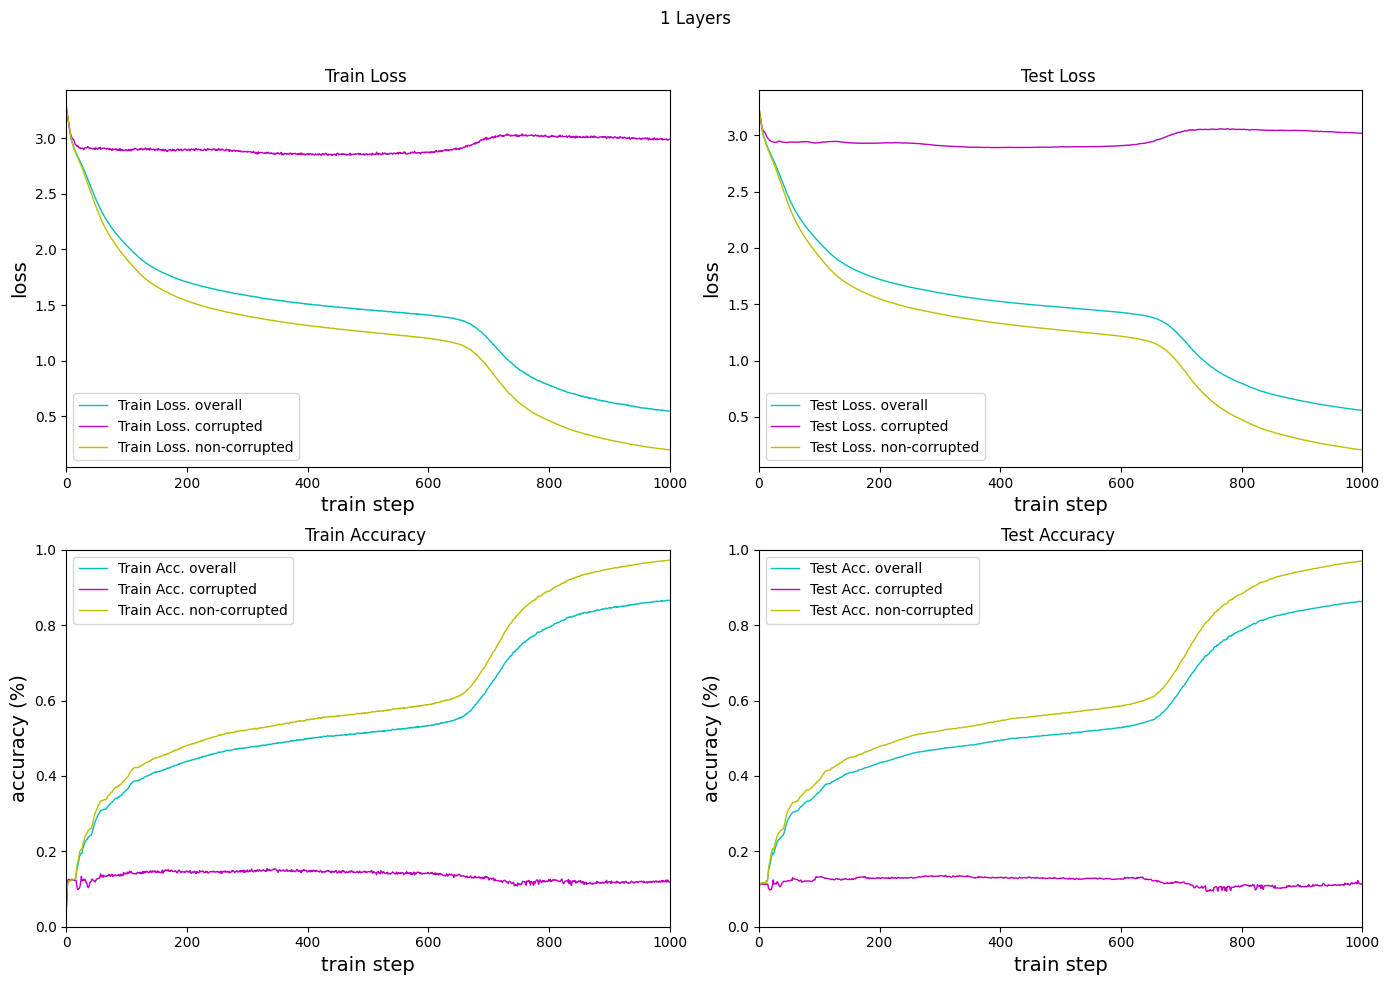

Epoch 0 	 Train Loss 3.286 	 Test Loss 3.26 	 Test Acc. (%)  7.2
Epoch 50 	 Train Loss 2.711 	 Test Loss 2.714 	 Test Acc. (%)  21.5
Epoch 100 	 Train Loss 2.179 	 Test Loss 2.188 	 Test Acc. (%)  33.5
Epoch 150 	 Train Loss 1.911 	 Test Loss 1.922 	 Test Acc. (%)  41.0
Epoch 200 	 Train Loss 1.719 	 Test Loss 1.735 	 Test Acc. (%)  45.3
Epoch 250 	 Train Loss 1.601 	 Test Loss 1.614 	 Test Acc. (%)  49.1
Epoch 300 	 Train Loss 1.272 	 Test Loss 1.278 	 Test Acc. (%)  63.9
Epoch 350 	 Train Loss 0.8 	 Test Loss 0.807 	 Test Acc. (%)  79.6
Epoch 400 	 Train Loss 0.587 	 Test Loss 0.596 	 Test Acc. (%)  85.4
Epoch 450 	 Train Loss 0.492 	 Test Loss 0.5 	 Test Acc. (%)  87.8
Epoch 500 	 Train Loss 0.446 	 Test Loss 0.454 	 Test Acc. (%)  88.6
Epoch 550 	 Train Loss 0.421 	 Test Loss 0.425 	 Test Acc. (%)  88.9
Epoch 600 	 Train Loss 0.399 	 Test Loss 0.406 	 Test Acc. (%)  89.1
Epoch 650 	 Train Loss 0.392 	 Test Loss 0.393 	 Test Acc. (%)  89.2
Epoch 700 	 Train Loss 0.378 	 Test Loss 0.

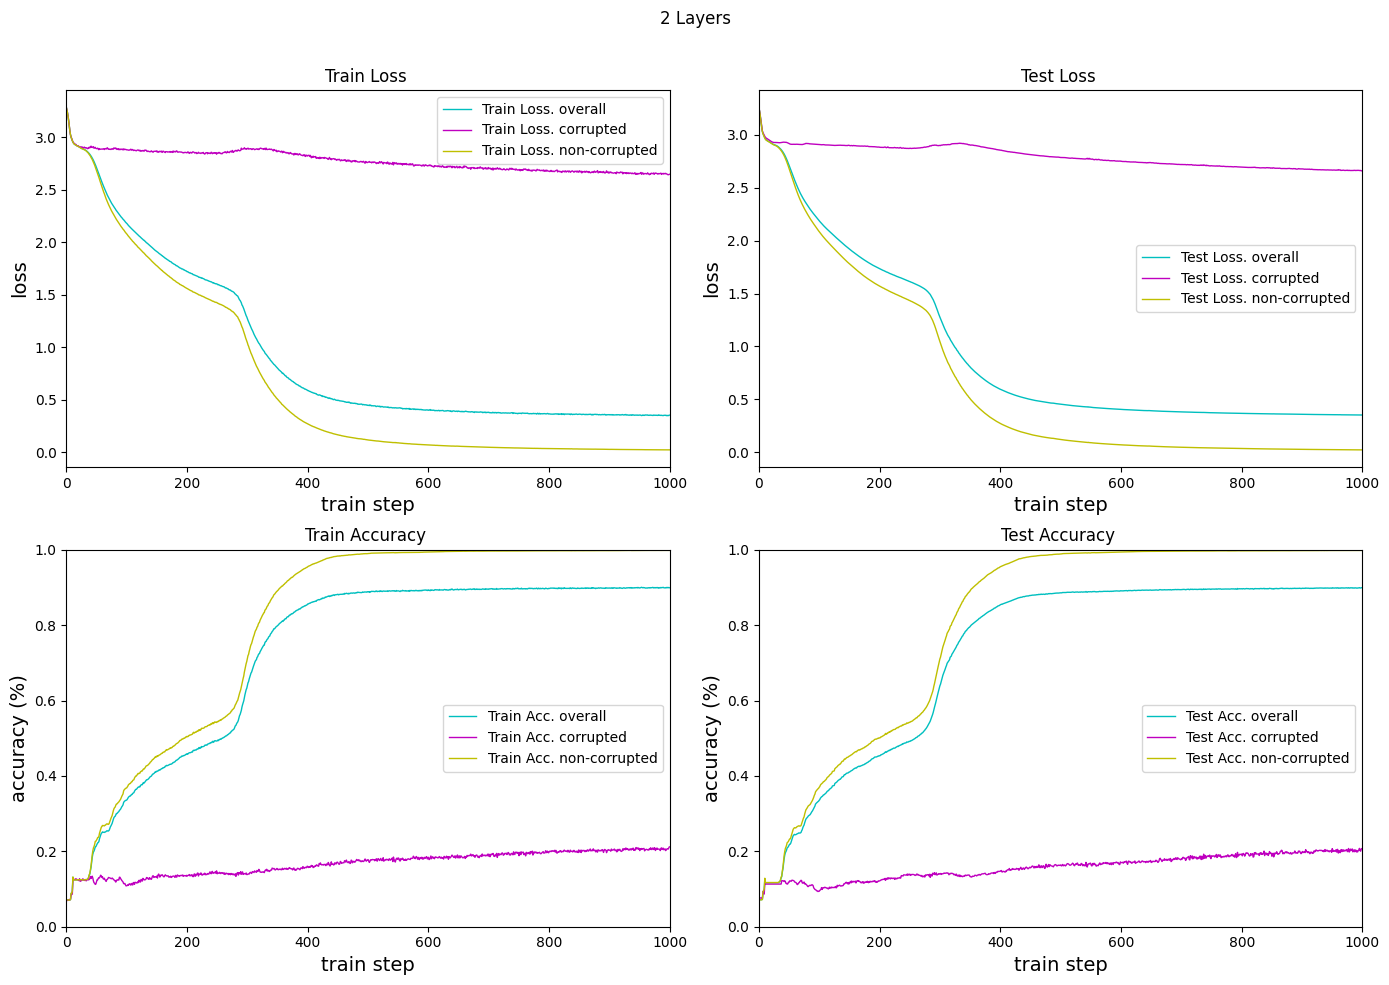

In [76]:
for n in num_layers:
    train_encrypted_dataset = CorruptedDataset(train_encrypted)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=n,
                                        num_letters=len(corr_vocab),
                                        hidden_size=16,
                                        use_lstm=True)

    num_epochs=1000
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title= str(n)+' Layers')

In [ ]:
for h in hidden_sizes:
    train_encrypted_dataset = CorruptedDataset(train_encrypted)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=2,
                                        num_letters=len(corr_vocab),
                                        hidden_size=h,
                                        use_lstm=True)

    num_epochs=1000
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title='hidden_size='+str(h))

Epoch 0 	 Train Loss 3.345 	 Test Loss 3.314 	 Test Acc. (%)  4.4
Epoch 50 	 Train Loss 2.39 	 Test Loss 2.483 	 Test Acc. (%)  26.1
Epoch 100 	 Train Loss 1.885 	 Test Loss 2.078 	 Test Acc. (%)  36.1
Epoch 150 	 Train Loss 1.652 	 Test Loss 1.912 	 Test Acc. (%)  39.0
Epoch 200 	 Train Loss 1.516 	 Test Loss 1.849 	 Test Acc. (%)  42.6
Epoch 250 	 Train Loss 1.41 	 Test Loss 1.832 	 Test Acc. (%)  45.1
Epoch 300 	 Train Loss 1.327 	 Test Loss 1.83 	 Test Acc. (%)  47.0
Epoch 350 	 Train Loss 1.26 	 Test Loss 1.837 	 Test Acc. (%)  48.5
Epoch 400 	 Train Loss 1.197 	 Test Loss 1.85 	 Test Acc. (%)  49.5
Epoch 450 	 Train Loss 1.132 	 Test Loss 1.873 	 Test Acc. (%)  50.9
Epoch 500 	 Train Loss 0.964 	 Test Loss 1.92 	 Test Acc. (%)  51.9
Epoch 550 	 Train Loss 0.614 	 Test Loss 2.228 	 Test Acc. (%)  48.5
Epoch 600 	 Train Loss 0.418 	 Test Loss 2.421 	 Test Acc. (%)  49.6
Epoch 650 	 Train Loss 0.301 	 Test Loss 2.585 	 Test Acc. (%)  50.2
Epoch 700 	 Train Loss 0.225 	 Test Loss 2.8

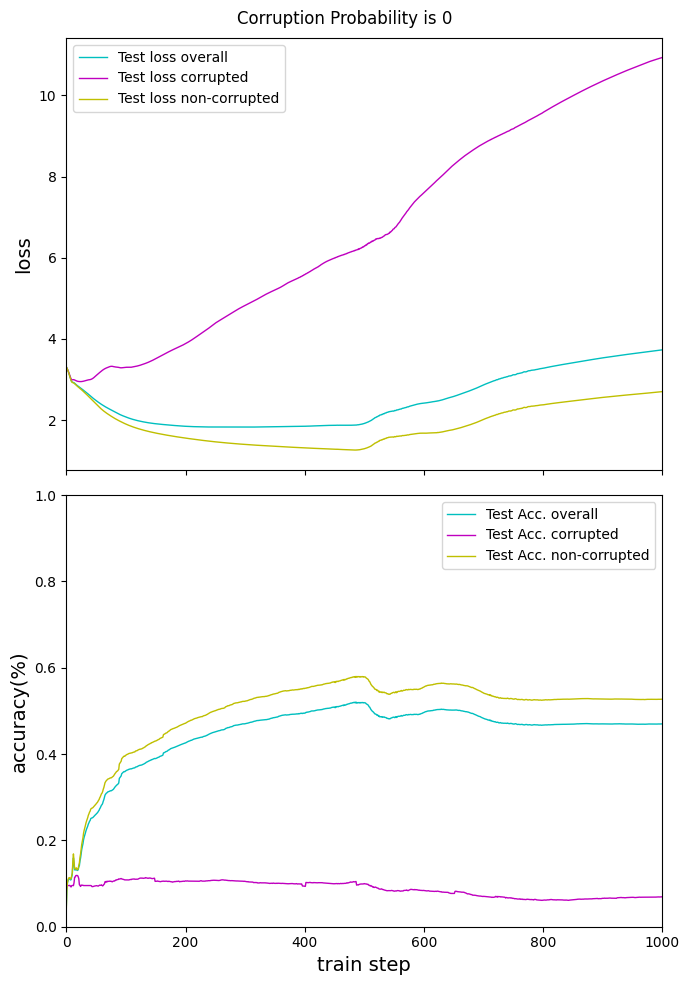

Epoch 0 	 Train Loss 3.314 	 Test Loss 3.285 	 Test Acc. (%)  4.3
Epoch 50 	 Train Loss 2.434 	 Test Loss 2.445 	 Test Acc. (%)  26.0
Epoch 100 	 Train Loss 2.021 	 Test Loss 2.032 	 Test Acc. (%)  35.1
Epoch 150 	 Train Loss 1.799 	 Test Loss 1.814 	 Test Acc. (%)  40.1
Epoch 200 	 Train Loss 1.686 	 Test Loss 1.701 	 Test Acc. (%)  43.6
Epoch 250 	 Train Loss 1.612 	 Test Loss 1.625 	 Test Acc. (%)  46.6
Epoch 300 	 Train Loss 1.546 	 Test Loss 1.557 	 Test Acc. (%)  49.9
Epoch 350 	 Train Loss 1.341 	 Test Loss 1.352 	 Test Acc. (%)  59.3
Epoch 400 	 Train Loss 0.996 	 Test Loss 1.01 	 Test Acc. (%)  72.7
Epoch 450 	 Train Loss 0.807 	 Test Loss 0.823 	 Test Acc. (%)  79.2
Epoch 500 	 Train Loss 0.689 	 Test Loss 0.7 	 Test Acc. (%)  83.2
Epoch 550 	 Train Loss 0.613 	 Test Loss 0.624 	 Test Acc. (%)  85.0
Epoch 600 	 Train Loss 0.566 	 Test Loss 0.578 	 Test Acc. (%)  86.1
Epoch 650 	 Train Loss 0.528 	 Test Loss 0.542 	 Test Acc. (%)  86.9
Epoch 700 	 Train Loss 0.506 	 Test Loss 

In [ ]:
for c in corruptions:
    train_encrypted_dataset = CorruptedDataset(train_encrypted, p=c)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=1,
                                        num_letters=len(corr_vocab),
                                        hidden_size=16,
                                        use_lstm=True)

    num_epochs=1000
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title='Corruption Probability is '+str(c))

### Definitive Parameters



In [ ]:
def_epochs = 1000
def_learning_rate = 1e-2
def_use_lstm = True
def_num_layer = 2
def_hidden_size = 32
def_corruption = 0.125

In [ ]:
train_encrypted_dataset = CorruptedDataset(train_encrypted, p=def_corruption)
train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

decrypter_network = CorruptedDecrypterNetwork(num_layers=def_num_layer,
                                    num_letters=len(corr_vocab),
                                    hidden_size=def_hidden_size,
                                    use_lstm=def_use_lstm)

num_epochs=def_epochs
CE_loss = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=def_learning_rate)

decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                            num_epochs,
                                                            CE_loss,
                                                            optimizer,
                                                            train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title='Final Model')